In [1]:
import numpy as np
import scanpy as sc
import scvelo as scv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import sys
import os
import gc
sys.path.append("..")

In [2]:
samples = ['CtcfWT29', 'Arid1aWTC3', 'Arid1aWTD3', 'Arid1aHetM3', 'Arid1aHomoM1', 'Arid1aHomoC2', 'CtcfHet30']

dataset_name = 'GCB'
model_type = 'DynaVelo'
num_hidden = 200
zx_dim = 50
zy_dim = 50
k_t = 1000
k_z0 = 1000
k_velocity = 10000
k_consistency = 10000
seed = 0

adata_rna_sample_list = []
adata_atac_sample_list = []
for i, sample_name in enumerate(samples):
    print(i)

    model_suffix = f'{dataset_name}_{sample_name}_{model_type}_num_hidden_{num_hidden}_zxdim_{zx_dim}_zydim_{zy_dim}_k_z0_{str(k_z0)}_k_t_{str(k_t)}_k_velocity_{str(k_velocity)}_k_consistency_{str(k_consistency)}_seed_{seed}'

    # load predicted RNA
    adata_rna_sample = sc.read_h5ad(f"/media/labuser/STORAGE/sc-multiome/data/MelnickLab_GerminalCenter_BCells/processed_data_rna/predicted/RNA_Matrix_Pred_{model_suffix}.h5ad")
    del adata_rna_sample.obsm['J_dvx_dx'], adata_rna_sample.obsm['J_dvx_dy'], adata_rna_sample.obsm['J_dvy_dx'],\
        adata_rna_sample.obsm['J_dvy_dy'], adata_rna_sample.obsm['delta_vx'], adata_rna_sample.obsm['delta_vy'],\
        adata_rna_sample.obsm['delta_vzx'], adata_rna_sample.obsm['delta_vzy'], adata_rna_sample.obsm['delta_latent_time']

    # load predicted ATAC
    adata_atac_sample = sc.read_h5ad(f"/media/labuser/STORAGE/sc-multiome/data/MelnickLab_GerminalCenter_BCells/processed_data_atac/MotifMatrix/predicted/Motif_Matrix_Pred_{model_suffix}.h5ad")

    # check if the cell names are the same
    assert all(adata_rna_sample.obs_names == adata_atac_sample.obs_names)

    adata_rna_sample_list.append(adata_rna_sample)
    adata_atac_sample_list.append(adata_atac_sample)

    del adata_rna_sample, adata_atac_sample
    gc.collect()


# concatenate predicted adatas
adata_rna_pred = adata_rna_sample_list[0].concatenate(adata_rna_sample_list[1], 
                                        adata_rna_sample_list[2], 
                                        adata_rna_sample_list[3],
                                        adata_rna_sample_list[4],
                                        adata_rna_sample_list[5],
                                        adata_rna_sample_list[6],
                                        batch_key='Sample', index_unique=None, 
                                        batch_categories=['CtcfWT29', 'Arid1aWTC3', 'Arid1aWTD3', 'Arid1aHetM3', 'Arid1aHomoM1', 'Arid1aHomoC2', 'CtcfHet30'])

adata_atac_pred = adata_atac_sample_list[0].concatenate(adata_atac_sample_list[1], 
                                        adata_atac_sample_list[2], 
                                        adata_atac_sample_list[3],
                                        adata_atac_sample_list[4],
                                        adata_atac_sample_list[5],
                                        adata_atac_sample_list[6],
                                        batch_key='Sample', index_unique=None, 
                                        batch_categories=['CtcfWT29', 'Arid1aWTC3', 'Arid1aWTD3', 'Arid1aHetM3', 'Arid1aHomoM1', 'Arid1aHomoC2', 'CtcfHet30'])

del adata_rna_sample_list, adata_atac_sample_list
gc.collect()


adata_atac_pred.obs['Genotype'] = pd.Categorical(adata_atac_pred.obs['Genotype'], categories=['WT', 'Arid1aHet', 'Arid1aHomo', 'CtcfHet'], ordered=True)
adata_atac_pred.obs['final.celltype'] = pd.Categorical(adata_atac_pred.obs['final.celltype'], categories=['Centroblast', 'Transitioning', 'Centrocyte', 'Plasmablast', 'Prememory'], ordered=True)
adata_atac_pred.obs['fine.celltype'] = pd.Categorical(adata_atac_pred.obs['fine.celltype'], categories=['Centroblast', 'Transitioning_CB_CC', 'Centrocyte', 'Transitioning_Sphase', 'CB_Rec_Sphase', 'CB_S_G2M', 'CB_G2M', 'Recycling', 'CC_Rec', 'Plasmablast', 'Prememory'], ordered=True)
adata_atac_pred.uns['Genotype_colors'] = ['#C3FF93', '#FFDB5C', '#FFAF61', '#FF70AB']
adata_atac_pred.uns['final.celltype_colors'] = ['#74c476', '#9ecae1', '#3182bd', '#1be7ff', '#e2a0ff']
adata_atac_pred.uns['fine.celltype_colors'] = ['#deebf7', '#9ecae1', '#3182bd', '#edf8e9', '#bae4b3', '#74c476', '#238b45', '#d94701', '#fd8d3c', '#1be7ff', '#e2a0ff']

adata_rna_pred.obs['Genotype'] = adata_atac_pred.obs['Genotype']
adata_rna_pred.obs['final.celltype'] = adata_atac_pred.obs['final.celltype']
adata_rna_pred.obs['fine.celltype'] = adata_atac_pred.obs['fine.celltype']
adata_rna_pred.uns['Genotype_colors'] = adata_atac_pred.uns['Genotype_colors']
adata_rna_pred.uns['final.celltype_colors'] = adata_atac_pred.uns['final.celltype_colors']
adata_rna_pred.uns['fine.celltype_colors'] = adata_atac_pred.uns['fine.celltype_colors']

0
1
2
3
4
5
6


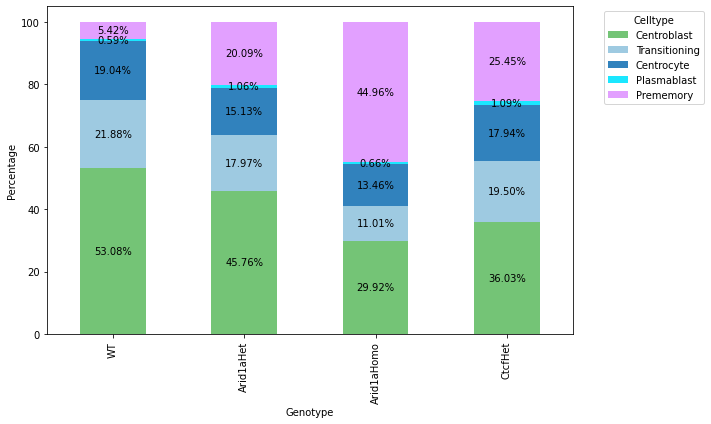

In [5]:
# percentage of each celltype in each genotype

fig_dir = f'../figures/Figs_supp'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

genotype_celltype_counts = adata_rna_pred.obs.groupby(['Genotype', 'final.celltype']).size().reset_index(name='counts')
genotype_totals = genotype_celltype_counts.groupby('Genotype')['counts'].sum().reset_index(name='total')
genotype_celltype_counts = genotype_celltype_counts.merge(genotype_totals, on='Genotype')
genotype_celltype_counts['percentage'] = (genotype_celltype_counts['counts'] / genotype_celltype_counts['total']) * 100

pivot_table = genotype_celltype_counts.pivot_table(index='Genotype', columns='final.celltype', values='percentage', fill_value=0)

# Create the bar chart
ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6), color=adata_rna_pred.uns['final.celltype_colors'])
plt.xlabel('Genotype')
plt.ylabel('Percentage')
#plt.title('Percentage of Cell Types in Genotype')
plt.legend(title='Celltype', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate the percentages
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', label_type='center')

# Show the plot
plt.tight_layout()
plt.grid(False)
plt.savefig(fig_dir+f'/celltype_percentage_in_each_genotype.pdf', bbox_inches="tight")